In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

In [10]:
def initialize_centers(labxy_image, gradient, num_superpixels, n=5):
    height, width = labxy_image.shape[:2]
    step = int(np.sqrt((height * width) / num_superpixels))
    centers_x = np.arange(step // 2, width, step)
    centers_y = np.arange(step // 2, height, step)
    centers_x, centers_y = np.meshgrid(centers_x, centers_y)
    centers_indices = np.stack((centers_x.flatten(), centers_y.flatten()), axis=-1)
    centers = labxy_image[centers_indices[:, 1], centers_indices[:, 0], :]

    for i, center in enumerate(centers):
        x_start = int(max(center[3] - n, 0))
        x_end = int(min(center[3] + n, width))
        y_start = int(max(center[4] - n, 0))
        y_end = int(min(center[4] + n, height))
        min_grad = np.inf
        for x in range(x_start, x_end):
            for y in range(y_start, y_end):
                if gradient[y, x] < min_grad:
                    min_grad = gradient[y, x]
                    centers[i] = labxy_image[y, x]

    return centers


def calculate_gradient(image):
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient = np.sum(gradient_x ** 2, axis=2) + np.sum(gradient_y ** 2, axis=2)
    return gradient


def assign_labels(labxy_image, image_mesh, centers, m, S):
    height, width = image.shape[:2]
    n_center = len(centers)
    labels = np.full((height, width), -1)
    distances = np.full((height, width), np.inf)

    for i, center in enumerate(centers):
        x_start = np.maximum(center[3] - S, 0).astype(int)
        x_end = np.minimum(center[3] + S, width).astype(int)
        y_start = np.maximum(center[4] - S, 0).astype(int)
        y_end = np.minimum(center[4] + S, height).astype(int)

        # for x in range(x_start, x_end):
        #     for y in range(y_start, y_end):
        #         d_lab = np.sqrt(np.sum((labxy_image[y, x, :3] - center[:3]) ** 2))
        #         d_xy = np.sqrt(np.sum((labxy_image[y, x, 3:] - center[3:]) ** 2))
        #         d = d_lab + m / S * d_xy
        #         if d < distances[y, x]:
        #             distances[y, x] = d
        #             labels[y, x] = i

        roi_lab = labxy_image[y_start:y_end, x_start:x_end, :3]
        roi_xy = labxy_image[y_start:y_end, x_start:x_end, 3:]

        d_lab = np.sqrt(np.sum((roi_lab - center[:3]) ** 2, axis=2))
        d_xy = np.sqrt(np.sum((roi_xy - center[3:]) ** 2, axis=2))
        d = d_lab + m / S * d_xy

        mask = d < distances[y_start:y_end, x_start:x_end]
        distances[y_start:y_end, x_start:x_end][mask] = d[mask]
        labels[y_start:y_end, x_start:x_end][mask] = i

    return labels


def update_centers(labxy_image, labels, centers):
    height, width = labxy_image.shape[:2]
    n_centers = centers.shape[0]
    new_centers = np.zeros_like(centers)

    for i in tqdm(range(n_centers)):
        indices = labels == i
        pixels = labxy_image.copy()
        pixels[indices == False] = [0, 0, 0, 0, 0]
        count = np.sum(indices)
        new_centers[i] = np.sum(pixels, axis=(0, 1)) / count

    residual_error = calculate_residual_error(new_centers, centers)
    return new_centers, residual_error


def calculate_residual_error(new_centers, centers):
    return np.sum(np.abs(new_centers - centers))


def slic_superpixels(image, num_superpixels, m=10, num_iterations=2, error_threshold=1e-3):
    height, width = image.shape[:2]
    S = np.sqrt((height * width) // num_superpixels)

    x_mesh, y_mesh = np.meshgrid(np.arange(0, width), np.arange(0, height))
    mesh = np.stack((x_mesh, y_mesh), axis=-1)
    labxy_image = np.concatenate((image, mesh), axis=2)

    gradient = calculate_gradient(image)
    centers = initialize_centers(labxy_image, gradient, num_superpixels)

    for _ in tqdm(range(num_iterations)):
        labels = assign_labels(labxy_image, mesh, centers, m, S)
        centers, residual_error = update_centers(labxy_image, labels, centers)
        if residual_error < error_threshold:
            break

    return labels


def visualize_boundaries(image, labels, thickness=2):
    boundaries = np.zeros_like(image)
    result = image.copy()
    for y in range(1, image.shape[0]):
        for x in range(1, image.shape[1]):
            current_label = labels[y, x]
            neighbors = [(y, x-1), (y-1, x)]
            for ny, nx in neighbors:
                if labels[ny, nx] != current_label:
                    boundaries[y, x] = 255
                    boundaries[ny, nx] = 255
                    result[y, x, :] = [255, 255, 255]
                    result[y, x, :] = [255, 255, 255]
    # result = cv2.addWeighted(image, 0.7, boundaries, 0.3, 0)
    return result, boundaries


def show_result(image, labels):
    segmented_image, boundaries = visualize_boundaries(image, labels)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.title('Superpixel Image')
    plt.subplot(1, 3, 3)
    plt.imshow(boundaries)
    plt.axis('off')
    plt.title('Image Boundraries')
    plt.show()

In [7]:
image = cv2.imread('brain.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

K=64, m=100

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

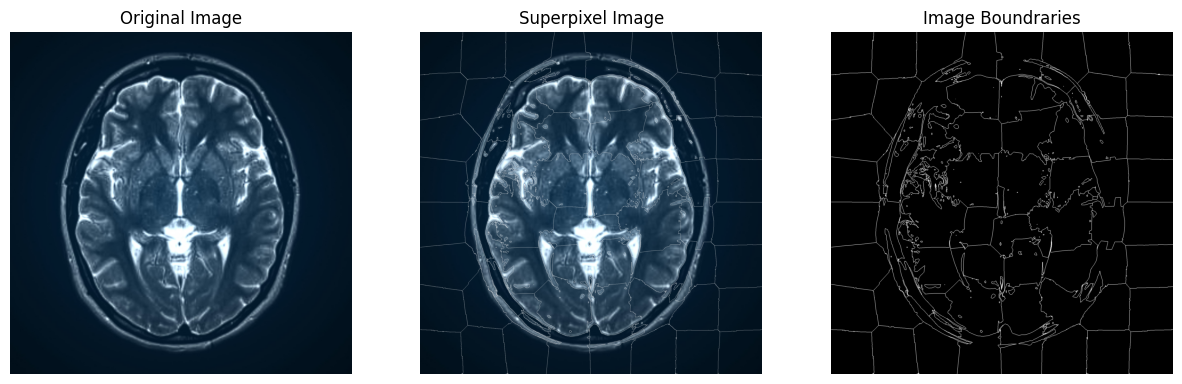

In [15]:
num_superpixels = 64
labels = slic_superpixels(lab_image, num_superpixels, m=100, num_iterations=2, error_threshold=1e-3)
show_result(image, labels)

K=64, m=50

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

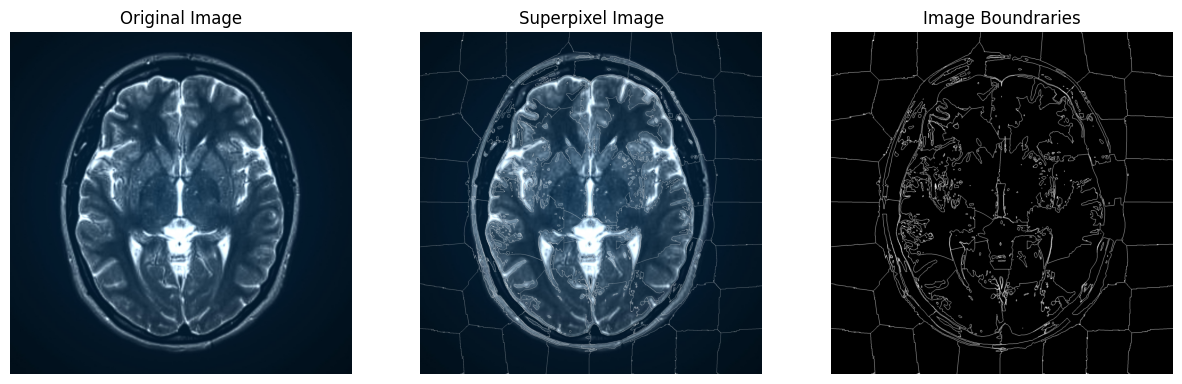

In [16]:
num_superpixels = 64
labels = slic_superpixels(lab_image, num_superpixels, m=50, num_iterations=2, error_threshold=1e-3)
show_result(image, labels)

K=64, m=10

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

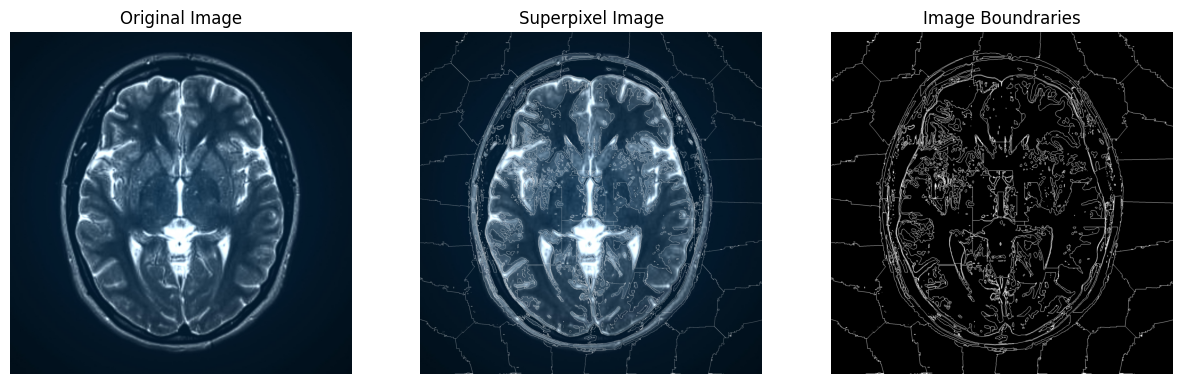

In [11]:
num_superpixels = 64
labels = slic_superpixels(lab_image, num_superpixels, m=10, num_iterations=2, error_threshold=1e-3)
show_result(image, labels)

K=256, m=10

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

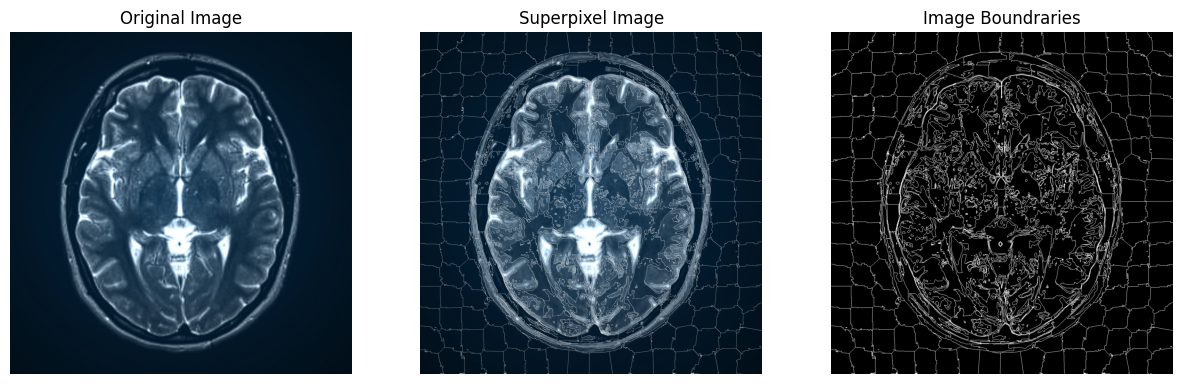

In [17]:
num_superpixels = 256
labels = slic_superpixels(lab_image, num_superpixels, m=10, num_iterations=2, error_threshold=1e-3)
show_result(image, labels)

K=1024, m=10

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

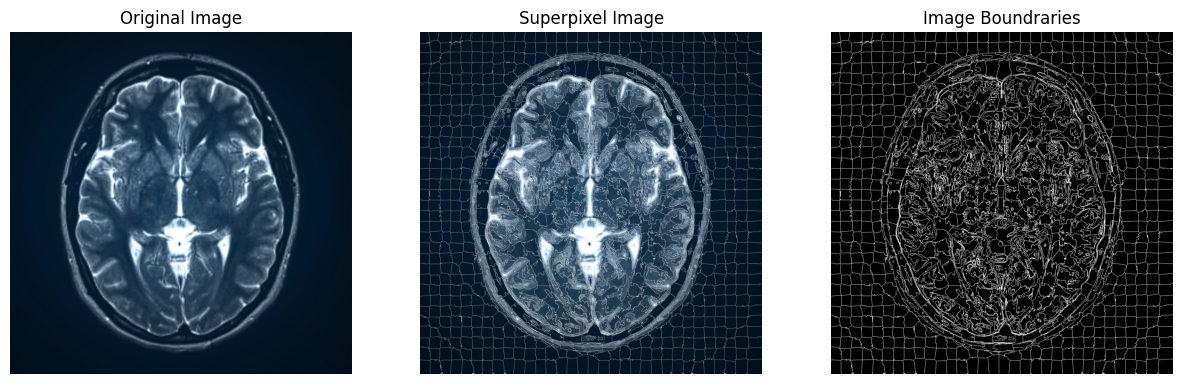

In [13]:
num_superpixels = 1024
labels = slic_superpixels(lab_image, num_superpixels, m=10, num_iterations=2, error_threshold=1e-3)
show_result(image, labels)